A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [1]:
import torch
import torch.nn as nn
import tiktoken
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# for reproducible results
m_seed = 369

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # vocabulary size
    "context_length": 1024, # context length
    "emb_dim": 768,         # embedding dimension
    "n_heads": 12,          # number of attention heads
    "n_layers": 12,         # number of layers / transformers
    "drop_rate": 0.1,       # dropout rate
    "qkv_bias": True        # Query-Key-Value bias
}

LAYER NORMALISATION

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

FEED FORWARD NETWORK USING GELU FUNCTION

In [6]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
         ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

MULTIHEAD ATTENTION

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_out = d_out
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_in, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vecs = (attn_weights @ values).transpose(1, 2)

        context_vecs = context_vecs.contiguous().view(b, num_tokens, self.d_out)
        context_vecs = self.out_proj(context_vecs)

        return context_vecs

TRANSFORMER

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.attn = MultiHeadAttention(
            num_heads=cfg["n_heads"],
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )

        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

GPT MODEL

In [9]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

CREATING GPT2 SMALL INSTANCE

In [10]:
torch.manual_seed(m_seed)

gpt = GPTModel(GPT_CONFIG_124M)
gpt.eval();

DOWNLOAD TRAINED WEIGHTS FROM OPENAI

In [11]:
from google.colab import files
uploaded = files.upload()

Saving download_gpt2.py to download_gpt2.py


In [12]:
from download_gpt2 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="models_gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 232kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.21MiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [13]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return nn.Parameter(torch.tensor(right))

In [14]:
def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        gpt.trf_blocks[b].attn.W_query.weight = assign(gpt.trf_blocks[b].attn.W_query.weight, q_w.T)
        gpt.trf_blocks[b].attn.W_key.weight = assign(gpt.trf_blocks[b].attn.W_key.weight, k_w.T)
        gpt.trf_blocks[b].attn.W_value.weight = assign(gpt.trf_blocks[b].attn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        gpt.trf_blocks[b].attn.W_query.bias = assign(gpt.trf_blocks[b].attn.W_query.bias, q_b)
        gpt.trf_blocks[b].attn.W_key.bias = assign(gpt.trf_blocks[b].attn.W_key.bias, k_b)
        gpt.trf_blocks[b].attn.W_value.bias = assign(gpt.trf_blocks[b].attn.W_value.bias, v_b)

        gpt.trf_blocks[b].attn.out_proj.weight = assign(
            gpt.trf_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].attn.out_proj.bias = assign(
            gpt.trf_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

        gpt.final_norm.scale = assign(gpt.final_norm.scale, params['g'])
        gpt.final_norm.shift = assign(gpt.final_norm.shift, params['b'])
        gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])

In [15]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

GENERATING TEXT

In [16]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    text = tokenizer.decode(flat.tolist())

    return text

In [17]:
def generate(model, idx, max_new_tokens, context_size, temperature=None, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_k_logits, _ = torch.topk(logits, top_k)
            min_val = top_k_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float("-inf")).to(logits.device),
                other=logits
            )

        t = temperature
        if t is None:
            t = 0.0

        if t > 0.0:
            logits = logits / t
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)

        if idx_next == eos_id:
            break

    return idx

In [18]:
for t_10 in range(5, 16, 2):
    temperature =  t_10 / 10

    torch.manual_seed(m_seed)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("I like the way you", tokenizer).to(device),
        max_new_tokens=50,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=50,
        temperature=temperature,
        eos_id=13 # dot(.)
    )

    # replace "\n" to make output more compact
    text = token_ids_to_text(token_ids, tokenizer).replace("\n", " ")
    print(f"Output text for t = {temperature}:\n", text)

Output text for t = 0.5:
 I like the way you look at it."  "It's not like you're saying anything about the people I'm with."  "But it's not like you're saying anything about me."  "But I think you're just saying what you like
Output text for t = 0.7:
 I like the way you look at it."  Hornett, who had been playing outside linebacker at the time, became interested in the game and played only 12 games in four seasons at Texas.
Output text for t = 0.9:
 I like the way you look," the woman said.
Output text for t = 1.1:
 I like the way you look," the woman added about what she would find in her apartment.
Output text for t = 1.3:
 I like the way you look," Sosa recalled about what had happened after the man pulled his dog to the street, where he asked to stay with his dog.
Output text for t = 1.5:
 I like the way you look," Sosa recalled about what had happened after the man pulled his dog to its handler's front yard on Wednesday night.


In [19]:
for t_10 in range(5, 16, 2):
    temperature =  t_10 / 10

    torch.manual_seed(m_seed)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("My hobby is to", tokenizer).to(device),
        max_new_tokens=50,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=50,
        temperature=temperature,
        eos_id=13 # dot(.)
    )

    # replace "\n" to make output more compact
    text = token_ids_to_text(token_ids, tokenizer).replace("\n", " ")
    print(f"Output text for t = {temperature}:\n", text)

Output text for t = 0.5:
 My hobby is to build a simple and simple game using the latest technologies.
Output text for t = 0.7:
 My hobby is to build small, high-quality LED's, and I've been doing this for over 5 years now.
Output text for t = 0.9:
 My hobby is to build small, high-quality LED's as they work.
Output text for t = 1.1:
 My hobby is to build small and fast wireless charging stations in my home gardens.
Output text for t = 1.3:
 My hobby is to help small and moderate kids navigate what life as a grown man should be like with no expectations placed upon them."  What I am proud of is that as much as I hope to give my fellow American children one day of a good life it is
Output text for t = 1.5:
 My hobby is to help small and moderate kids navigate what life as a grown man should be like with no expectations placed upon them."  What I am proud of is that as much as I hope our movement could turn away from the traditional notions that young people tend to


In [20]:
for t_10 in range(5, 16, 2):
    temperature =  t_10 / 10

    torch.manual_seed(m_seed)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Honesty is the best", tokenizer).to(device),
        max_new_tokens=50,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=50,
        temperature=temperature,
        eos_id=13 # dot(.)
    )

    # replace "\n" to make output more compact
    text = token_ids_to_text(token_ids, tokenizer).replace("\n", " ")
    print(f"Output text for t = {temperature}:\n", text)

Output text for t = 0.5:
 Honesty is the best way to know what's going on in the world," he said.
Output text for t = 0.7:
 Honesty is the best way to know what's going on in the world," he added.
Output text for t = 0.9:
 Honesty is the best way to know what's about to happen as a manager.
Output text for t = 1.1:
 Honesty is the best way to know what's about to happen as a manager.
Output text for t = 1.3:
 Honesty is the best way to know when or where people are taking action -- but there might be reasons to keep your hand at the door.
Output text for t = 1.5:
 Honesty is the best way to know you know about what's taking place -- but if you let somebody down right away...what kind of message does it send...that it gets you down? What a waste of time and money....you want proof that they lied? Oh


INSTRUCTION FINETUNING

In [21]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [22]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


CONVERTING INSTRUCTION INTO ALPACA FORMAT

In [23]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [24]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


SPLITING DATASET INTO TRAIN-TEST-VALIDATION

In [25]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [26]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


STEP 2 - ORGANIZING DATA INTO TRAINING BATCHES

In [27]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [28]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [29]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

Example of padding inputs to same length

In [30]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


CREATING TARGET TOKEN IDS FOR TRAINING

In [31]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [32]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [33]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

MASKING OUT PADDED TOKENS

In [34]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [35]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


STEP 3 - CREATING DATALOADERS FOR INSTRUCTION DATASET

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [38]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [39]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [40]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

STEP 4 - LOADING A PRETRAINED LLM

In [43]:
from download_gpt2 import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="models_gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/checkpoint


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/encoder.json


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/hparams.json


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/model.ckpt.data-00000-of-00001


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/model.ckpt.index


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/model.ckpt.meta


/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and up-to-date:  models_gpt2/124M/vocab.bpe


Let's assess the performance by comparing its output with expecte response.

In [44]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [51]:
token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=35,
        context_size=GPT_CONFIG_124M["context_length"],
        #top_k=50,
        eos_id=13 # dot(.)
    )
text = token_ids_to_text(token_ids, tokenizer)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


As we can see from the output, the pretrained model is not yet capable of correctly following the given instruction.

It simply repeats the original input sentence and part of the instruction, failing to convert the active sentence to passive voice as requested.

STEP 5 - FINETUNING LLM ON INSTRUCTION DATA

In [55]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [57]:
gpt.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, gpt, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.1671394348144535
Validation loss: 4.050935888290406


In [59]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [61]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [63]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [64]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.497, Val loss 0.772
Ep 1 (Step 000005): Train loss 0.637, Val loss 0.816
Ep 1 (Step 000010): Train loss 0.538, Val loss 0.829
Ep 1 (Step 000015): Train loss 0.592, Val loss 0.831
Ep 1 (Step 000020): Train loss 0.516, Val loss 0.838
Ep 1 (Step 000025): Train loss 0.514, Val loss 0.841
Ep 1 (Step 000030): Train loss 0.568, Val loss 0.849
Ep 1 (Step 000035): Train loss 0.554, Val loss 0.839
Ep 1 (Step 000040): Train loss 0.524, Val loss 0.836
Ep 1 (Step 000045): Train loss 0.510, Val loss 0.842
Ep 1 (Step 000050): Train loss 0.545, Val loss 0.856
Ep 1 (Step 000055): Train loss 0.669, Val loss 0.868
Ep 1 (Step 000060): Train loss 0.552, Val loss 0.864
Ep 1 (Step 000065): Train loss 0.540, Val loss 0.848
Ep 1 (Step 000070): Train loss 0.450, Val loss 0.821
Ep 1 (Step 000075): Train loss 0.479, Val loss 0.823
Ep 1 (Step 000080): Train loss 0.535, Val loss 0.845
Ep 1 (Step 000085): Train loss 0.454, Val loss 0.849
Ep 1 (Step 000090): Train loss 0.514, Val loss

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

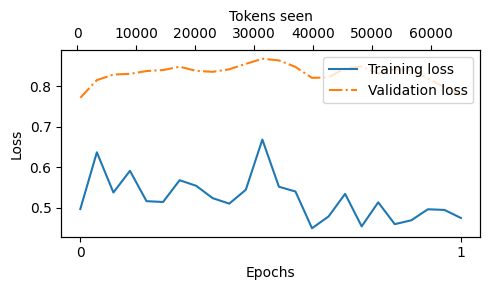

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

STEP 6 - EXTRACTING AND SAVING RESPONSE

In [68]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=GPT_CONFIG_124M["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is a fast car.<|endoftext|>
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is the active component cloud.<|endoftext|>
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model resp

In [70]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=GPT_CONFIG_124M["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [00:41<00:00,  2.66it/s]


In [71]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.<|endoftext|>'}


In [72]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(gpt.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth
